## 1. Importando Bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import spacy
from nltk import tokenize, RSLPStemmer, FreqDist, tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.lm import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report, make_scorer
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
from string import punctuation
from time import time
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from gensim.models.word2vec import Word2Vec
from collections import defaultdict
from yellowbrick.classifier import ROCAUC
from sklearn.preprocessing import LabelEncoder
from yellowbrick.classifier import PrecisionRecallCurve


from utils.regex_utils import *
from utils.stopword_utils import RemoverStopwords
from utils.normalize_utils import ProcessoNormalizacao
from utils.stemming_utils import ProcessoStemming
from utils.lemmatization_utils import ProcessoLemmatization
from utils.features_extract import ExtracaoFeatures, E2V_IDF
from utils.n_grams_utils import ngrams_count
from utils.wordcloud_utils import nuvem_palavras
from utils.select_model_utils import print_score_BayesSearchCV, print_score
from utils.word2vec_utils import E2V_IDF
from utils.pos_tag_filter_utils import ProcessoFilterPosTag

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Brothers\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\Brothers\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Brothers\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 2. Leitura dos dados

In [2]:
dataset = pd.read_csv('order_reviews.csv', sep=';')
dataset.head()

review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score review_comment_title  \
0             4                  NaN   
1             5                  NaN   
2             5                  NaN   
3             5                  NaN   
4             5                  NaN   

                              review_comment_message review_creation_date  \
0                                                NaN  2018-01-18 00:00:00   
1                                                NaN  2018-03-10 00:00:00   
2                                                NaN  2018-02-17 00:00:00   
3              Recebi bem antes do prazo estipulado.  2017-04-21 00:00:00   
4  Parab√©ns lojas lannister adorei comprar pela I...  2018-03-01 00:00:00   

  review_answer_timestamp  
0     2018-01-18 21:46:59  
1     2018-03-11 03:05:13  
2     2018-02-18 14:36:24  
3     2017-04-21 22:02:06  
4     2018-03-02 10:26:53

## 3. Compreens√£o de dados

In [3]:
dataset.drop(['review_id', 'review_creation_date', 'review_answer_timestamp', 'review_comment_title', 'order_id'], axis=1, inplace=True)

# Retirando o valores Null de reviews
dataset = dataset.dropna()
dataset = dataset.reset_index(drop=True)
dataset.shape

(40977, 2)

In [4]:
dataset.head()

review_score                             review_comment_message
0             5              Recebi bem antes do prazo estipulado.
1             5  Parab√©ns lojas lannister adorei comprar pela I...
2             4  aparelho eficiente. no site a marca do aparelh...
3             4    Mas um pouco ,travando...pelo valor ta Boa.\r\n
4             5  Vendedor confi√°vel, produto ok e entrega antes...

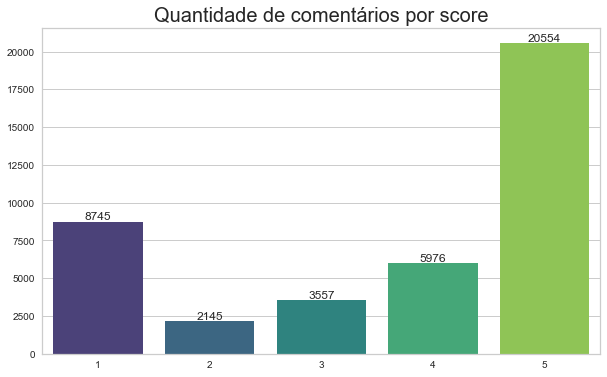

In [5]:
# Criando um datafrem que contem as quantidade de acordo com o score
quantidade = pd.DataFrame(dataset['review_score'].value_counts()).sort_index()

# plotando o gr√°fico de barra
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(y='review_score', x=quantidade.index, data=quantidade, orient='v', palette='viridis')
ax.set_title('Quantidade de coment√°rios por score', fontdict={'fontsize': 20})
ax.set(ylabel=None, xlabel=None)
ax.bar_label(ax.containers[0])
plt.show()

In [6]:
# Rotulagem dos dados
score_map = {
    1: -1,
    2: -1,
    3: 0,
    4: 1,
    5: 1
}

dataset['sentiment_label'] = dataset['review_score'].map(score_map)
dataset = dataset[['review_score', 'sentiment_label','review_comment_message']]
dataset.head()

review_score  sentiment_label  \
0             5                1   
1             5                1   
2             4                1   
3             4                1   
4             5                1   

                              review_comment_message  
0              Recebi bem antes do prazo estipulado.  
1  Parab√©ns lojas lannister adorei comprar pela I...  
2  aparelho eficiente. no site a marca do aparelh...  
3    Mas um pouco ,travando...pelo valor ta Boa.\r\n  
4  Vendedor confi√°vel, produto ok e entrega antes...

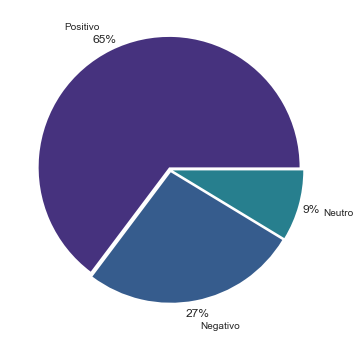

In [7]:
sentiment = pd.DataFrame(dataset['sentiment_label'].value_counts())
labels = ['Positivo', 'Negativo', 'Neutro']

fig, ax = plt.subplots(figsize=(10, 6))
colors = sns.color_palette('viridis')
ax.pie(sentiment['sentiment_label'],labels= labels,autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2, explode = [0.02, 0.02, 0.02], colors=colors)
plt.show()

## 5. Aplicando Lemmatization aos reviews

A Lemmatization buscar reduzir a palavra √† sua raiz, retirando todas as inflex√µes e chegando ao lemma. Por√©m, essa redu√ß√£o sempre resultar√° em uma palavra que realmente existe na gram√°tica. Outro ponto importante √© que, nessa t√©cnica, a classe gramatical da palavra ser√° levada em considera√ß√£o para fazer a redu√ß√£o;

In [8]:
# definindo X e y 
comentarios = dataset['review_comment_message'].dropna().index
score = dataset['review_score'][comentarios].map({1: 'negativo', 2: 'negativo', 3: 'neutro', 4: 'positivo', 5: 'positivo'})

# Dfinido X e y 
X = list(dataset['review_comment_message'][comentarios].values)
y = score.values


# Definindo todas as trafoma√ß√µes regex para serem aplicadas ao pipeline
regex_transformers = {
    'datas': re_dates,
    'valores_dinheiro': re_money,
    'numeros': re_numbers,
    'negacoes': re_negation,
    'caracteres_especiais': re_special_chars,
    'espacos_branco': re_whitespaces
}


# Criando o Pipeline
text_pipeline = Pipeline([
    ('regex', RemoverRegex(regex_transformers)),
    ('stopwords', RemoverStopwords(stopwords.words('portuguese'))),
    ('normalization', ProcessoNormalizacao()),
    ('lemmatization', ProcessoLemmatization())
])

# Aplicando o pipeline
X_processed = text_pipeline.fit_transform(X)

Salvando os dados processados em um arquivo .csv:

In [9]:
dataset['review_lemma'] = X_processed
dataset.to_csv('order_review_lemma.csv', sep=';', index=False)

Lendo os novos dados criados a partir da Lemmatization:

In [18]:
dataset = pd.read_csv('datasets/order_review_lemma.csv', sep=';')
dataset.head()

review_score  sentiment_label  \
0             5                1   
1             5                1   
2             4                1   
3             4                1   
4             5                1   

                              review_comment_message  \
0              Recebi bem antes do prazo estipulado.   
1  Parab√©ns lojas lannister adorei comprar pela I...   
2  aparelho eficiente. no site a marca do aparelh...   
3    Mas um pouco ,travando...pelo valor ta Boa.\r\n   
4  Vendedor confi√°vel, produto ok e entrega antes...   

                                        review_lemma  
0                   recebi bem antes prazo estipular  
1  parabem loja lannister adorei comprar Internet...  
2  aparelho eficiente site marca aparelho impress...  
3                          pouco travar valor ta bom  
4  vendedor confiavel produto ok entregar antes p...

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40977 entries, 0 to 40976
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_score            40977 non-null  int64 
 1   sentiment_label         40977 non-null  int64 
 2   review_comment_message  40977 non-null  object
 3   review_lemma            40817 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.3+ MB


In [7]:
dataset[dataset['review_lemma'].isna()]

review_score  sentiment_label    review_comment_message review_lemma
125               5                1                         A          NaN
409               4                1       *******************          NaN
1025              1               -1                         A          NaN
1411              5                1                       . .          NaN
1426              4                1                        **          NaN
...             ...              ...                       ...          ...
38888             5                1                         .          NaN
39117             5                1  ........................          NaN
39974             5                1                    üëçüèªüëåüèªüëèüèª          NaN
40302             4                1                         -          NaN
40780             5                1          üëçüëçüëçüëçüëçüëçüëçüëçüëèüëèüëèüëèüëèüëèüëèüëè          NaN

[160 rows x 4 columns]

In [3]:
dataset = dataset.dropna()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40817 entries, 0 to 40976
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_score            40817 non-null  int64 
 1   sentiment_label         40817 non-null  int64 
 2   review_comment_message  40817 non-null  object
 3   review_lemma            40817 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.6+ MB


### 5.1 Criando um modelo de LogisticRegressor com a nova base de dados

In [14]:
vectorizer = CountVectorizer(min_df=5)
contagem_de_palavras = vectorizer.fit_transform(dataset['review_lemma']).toarray()
features_names = vectorizer.get_feature_names_out()
df_corpus_features = pd.DataFrame(contagem_de_palavras, columns=features_names)
print(df_corpus_features.shape)
df_corpus_features

(40817, 2818)


2e  abaixo  abajur  abencoe  aberto  aborrecer  abraco  abri  abril  \
0       0       0       0        0       0          0       0     0      0   
1       0       0       0        0       0          0       0     0      0   
2       0       0       0        0       0          0       0     0      0   
3       0       0       0        0       0          0       0     0      0   
4       0       0       0        0       0          0       0     0      0   
...    ..     ...     ...      ...     ...        ...     ...   ...    ...   
40812   0       0       0        0       0          0       0     0      0   
40813   0       0       0        0       0          0       0     0      0   
40814   0       0       0        0       0          0       0     0      0   
40815   0       0       0        0       0          0       0     0      0   
40816   0       0       0        0       0          0       0     0      0   

       abrir  ...  xa  xbox  xerox  xicara  xl  xperia  xxx  zenfone  zero  \
0          0  ...   0     0      0       0   0       0    0        0     0   
1          0  ...   0     0      0       0   0       0    0        0     0   
2          0  ...   0     0      0       0   0       0    0        0     0   
3          0  ...   0     0      0       0   0       0    0        0     0   
4          0  ...   0     0      0       0   0       0    0        0     0   
...      ...  ...  ..   ...    ...     ...  ..     ...  ...      ...   ...   
40812      0  ...   0     0      0       0   0       0    0        0     0   
40813      0  ...   0     0      0       0   0       0    0        0     0   
40814      0  ...   0     0      0       0   0       0    0        0     0   
40815      0  ...   0     0      0       0   0       0    0        0     0   
40816      0  ...   0     0      0       0   0       0    0        0     0   

       ziper  
0          0  
1          0  
2          0  
3          0  
4          0  
...      ...  
40812      0  
40813      0  
40814      0  
40815      0  
40816      0  

[40817 rows x 2818 columns]

In [15]:
ocorrencia = df_corpus_features.sum(axis=0)
print('Quantidades de palavras: ', len(ocorrencia))
ocorrencia.sort_values(ascending=False)

Quantidades de palavras:  2818


produto              19690
negacao              12317
entregar             10993
prazo                 8523
numero                7142
                     ...  
cabivel                  5
caimento                 5
queda                    5
gentil                   5
indisponibilidade        5
Length: 2818, dtype: int64

In [16]:
ocorrencia.sort_values(ascending=False)[:28]

produto      19690
negacao      12317
entregar     10993
prazo         8523
numero        7142
chegar        6423
bom           6307
antes         5627
recebi        5039
vir           3820
otimo         3353
bem           3112
loja          2786
qualidade     2784
recomendo     2465
comprar       2465
gostar        2344
ainda         2339
tudo          2332
dia           2029
compra        1973
compr         1922
rapir         1881
excelente     1848
pedir         1790
super         1727
esperar       1484
dentro        1460
dtype: int64

In [17]:
ocorrencia.sort_values(ascending=True)[:28]

representante    5
grevar           5
escola           5
sertinho         5
grudar           5
publicacao       5
play             5
publicar         5
equivocar        5
hiper            5
equivalente      5
manda            5
homem            5
sera             5
separacao        5
atendida         5
pistao           5
color            5
proximos         5
entreguem        5
touco            5
cobr             5
cinto            5
babar            5
tomarar          5
tomeir           5
avisaram         5
podera           5
dtype: int64

In [6]:
# Vetorizando as 50 palavras com mais ocorr√™ncia da coluna "review_comment_message"
vectorizer = TfidfVectorizer(min_df=5) # Remover as ocorr√™ncias que s√£o menores que 2x
corpus_features = vectorizer.fit_transform(dataset['review_lemma']).toarray()
features_names = vectorizer.get_feature_names_out()
df_corpus_features = pd.DataFrame(corpus_features, columns=features_names)
print(df_corpus_features.shape)
df_corpus_features

(40817, 2818)


2e  abaixo  abajur  abencoe  aberto  aborrecer  abraco  abri  abril  \
0      0.0     0.0     0.0      0.0     0.0        0.0     0.0   0.0    0.0   
1      0.0     0.0     0.0      0.0     0.0        0.0     0.0   0.0    0.0   
2      0.0     0.0     0.0      0.0     0.0        0.0     0.0   0.0    0.0   
3      0.0     0.0     0.0      0.0     0.0        0.0     0.0   0.0    0.0   
4      0.0     0.0     0.0      0.0     0.0        0.0     0.0   0.0    0.0   
...    ...     ...     ...      ...     ...        ...     ...   ...    ...   
40812  0.0     0.0     0.0      0.0     0.0        0.0     0.0   0.0    0.0   
40813  0.0     0.0     0.0      0.0     0.0        0.0     0.0   0.0    0.0   
40814  0.0     0.0     0.0      0.0     0.0        0.0     0.0   0.0    0.0   
40815  0.0     0.0     0.0      0.0     0.0        0.0     0.0   0.0    0.0   
40816  0.0     0.0     0.0      0.0     0.0        0.0     0.0   0.0    0.0   

       abrir  ...   xa  xbox  xerox  xicara   xl  xperia  xxx  zenfone  zero  \
0        0.0  ...  0.0   0.0    0.0     0.0  0.0     0.0  0.0      0.0   0.0   
1        0.0  ...  0.0   0.0    0.0     0.0  0.0     0.0  0.0      0.0   0.0   
2        0.0  ...  0.0   0.0    0.0     0.0  0.0     0.0  0.0      0.0   0.0   
3        0.0  ...  0.0   0.0    0.0     0.0  0.0     0.0  0.0      0.0   0.0   
4        0.0  ...  0.0   0.0    0.0     0.0  0.0     0.0  0.0      0.0   0.0   
...      ...  ...  ...   ...    ...     ...  ...     ...  ...      ...   ...   
40812    0.0  ...  0.0   0.0    0.0     0.0  0.0     0.0  0.0      0.0   0.0   
40813    0.0  ...  0.0   0.0    0.0     0.0  0.0     0.0  0.0      0.0   0.0   
40814    0.0  ...  0.0   0.0    0.0     0.0  0.0     0.0  0.0      0.0   0.0   
40815    0.0  ...  0.0   0.0    0.0     0.0  0.0     0.0  0.0      0.0   0.0   
40816    0.0  ...  0.0   0.0    0.0     0.0  0.0     0.0  0.0      0.0   0.0   

       ziper  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0  
...      ...  
40812    0.0  
40813    0.0  
40814    0.0  
40815    0.0  
40816    0.0  

[40817 rows x 2818 columns]

In [5]:
# Definindo X e y
X = corpus_features
y = dataset['sentiment_label'].map({-1: 'negativo', 0: 'neutro', 1: 'positivo'})


# Cria 3 parti√ß√µes com os dados de dispon√≠veis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, y)


for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    regressao_logistica = LogisticRegression(solver = "saga", multi_class='multinomial', max_iter=300)
    
    regressao_logistica.fit(X_train, y_train)
    y_true, y_pred = y_test, regressao_logistica.predict(X_test)
    score = f1_score(y_true, y_pred, average='weighted')
    print(f'f1_score: {score}')
    print(classification_report(y_true, y_pred))

f1_score: 0.767367159219424
              precision    recall  f1-score   support

    negativo       0.74      0.69      0.71      3627
      neutro       0.39      0.05      0.10      1182
    positivo       0.82      0.94      0.88      8797

    accuracy                           0.80     13606
   macro avg       0.65      0.56      0.56     13606
weighted avg       0.76      0.80      0.77     13606

f1_score: 0.7680081818130988
              precision    recall  f1-score   support

    negativo       0.74      0.70      0.72      3626
      neutro       0.34      0.04      0.07      1183
    positivo       0.83      0.94      0.88      8797

    accuracy                           0.80     13606
   macro avg       0.64      0.56      0.56     13606
weighted avg       0.76      0.80      0.77     13606

f1_score: 0.7643683420238645
              precision    recall  f1-score   support

    negativo       0.73      0.70      0.72      3626
      neutro       0.29      0.03      0.06

## 6. Aplicando Filtro Pos Tag aos reviews

### 6.1. Removendo Verbos

In [ ]:
# definindo X e y 
comentarios = dataset['review_lemma'].index
score = dataset['review_score'][comentarios].map({1: 'negativo', 2: 'negativo', 3: 'neutro', 4: 'positivo', 5: 'positivo'})

# Dfinido X e y 
X = list(dataset['review_lemma'][comentarios].values)
y = score.values

# Criando o Pipeline
text_pipeline = Pipeline([
    ('filter_pos_tag', ProcessoFilterPosTag(("VERB")))
])

# Aplicando o pipeline
X_processed = text_pipeline.fit_transform(X)

Salvando o novo tratamento em um novo arquivo .csv:

In [ ]:
dataset['filter_pos_tag'] = X_processed
dataset.to_csv('order_review_filter_pos_tag_verb.csv', sep=';', index=False)

In [2]:
# Carregando o arquivo salvo
dataset = pd.read_csv('datasets/order_review_filter_pos_tag_verb.csv', sep=';')
dataset.head()

review_score  sentiment_label  \
0             5                1   
1             5                1   
2             4                1   
3             4                1   
4             5                1   

                              review_comment_message  \
0              Recebi bem antes do prazo estipulado.   
1  Parab√©ns lojas lannister adorei comprar pela I...   
2  aparelho eficiente. no site a marca do aparelh...   
3    Mas um pouco ,travando...pelo valor ta Boa.\r\n   
4  Vendedor confi√°vel, produto ok e entrega antes...   

                                        review_lemma  \
0                   recebi bem antes prazo estipular   
1  parabem loja lannister adorei comprar Internet...   
2  aparelho eficiente site marca aparelho impress...   
3                          pouco travar valor ta bom   
4  vendedor confiavel produto ok entregar antes p...   

                               review_filter_pos_tag  
0                          bem antes prazo estipular  
1  loja lannister Internet seguro pratico parabem...  
2  aparelho eficiente site marca aparelho numero ...  
3                                 pouco valor ta bom  
4          vendedor confiavel produto ok antes prazo

In [22]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40817 entries, 0 to 40816
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_score            40817 non-null  int64 
 1   sentiment_label         40817 non-null  int64 
 2   review_comment_message  40817 non-null  object
 3   review_lemma            40817 non-null  object
 4   review_filter_pos_tag   39894 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.6+ MB


In [23]:
dataset[dataset['review_filter_pos_tag'].isna()]

review_score  sentiment_label  \
26                5                1   
55                3                0   
65                5                1   
67                1               -1   
187               5                1   
...             ...              ...   
40674             4                1   
40694             5                1   
40711             5                1   
40760             1               -1   
40806             4                1   

                                  review_comment_message  \
26               Amei achei lindo ,muito delicado adorei   
55                                               Gostei    
65                       Gostei da aten√ß√£o com a entrega   
67                                     A pe√ßa n√£o serviu   
187                                              Gostei!   
...                                                  ...   
40674                                     o filho gostou   
40694                                               amei   
40711                                 Lindo recomendo !    
40760  Meus pedidos est√£o dando como entregues , mais...   
40806                                          Aprovado!   

                                     review_lemma review_filter_pos_tag  
26                 ameir achar lir delicar adorei                   NaN  
55                                         gostar                   NaN  
65                        gostar atencao entregar                   NaN  
67                           pecar negacao servir                   NaN  
187                                        gostar                   NaN  
...                                           ...                   ...  
40674                                filho gostar                   NaN  
40694                                       ameir                   NaN  
40711                               lir recomendo                   NaN  
40760  pedido dar entregar negacao recebi luminar                   NaN  
40806                                     aprovar                   NaN  

[923 rows x 5 columns]

In [24]:
dataset = dataset.dropna()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39894 entries, 0 to 40816
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_score            39894 non-null  int64 
 1   sentiment_label         39894 non-null  int64 
 2   review_comment_message  39894 non-null  object
 3   review_lemma            39894 non-null  object
 4   review_filter_pos_tag   39894 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.8+ MB


#### 6.1.1. Criando um modelo de LogisticRegressor com a nova base de dados

In [25]:
# Vetorizando as 50 palavras com mais ocorr√™ncia da coluna "review_comment_message"
vectorizer = TfidfVectorizer(min_df=5)
corpus_features = vectorizer.fit_transform(dataset['review_filter_pos_tag']).toarray()
features_names = vectorizer.get_feature_names_out()
df_corpus_features = pd.DataFrame(corpus_features, columns=features_names)
print(df_corpus_features.shape)
df_corpus_features

(39894, 1979)


2e  abaixo  abencoe  abraco  abri  abril  absurdo  acabado  \
0      0.0     0.0      0.0     0.0   0.0    0.0      0.0      0.0   
1      0.0     0.0      0.0     0.0   0.0    0.0      0.0      0.0   
2      0.0     0.0      0.0     0.0   0.0    0.0      0.0      0.0   
3      0.0     0.0      0.0     0.0   0.0    0.0      0.0      0.0   
4      0.0     0.0      0.0     0.0   0.0    0.0      0.0      0.0   
...    ...     ...      ...     ...   ...    ...      ...      ...   
39889  0.0     0.0      0.0     0.0   0.0    0.0      0.0      0.0   
39890  0.0     0.0      0.0     0.0   0.0    0.0      0.0      0.0   
39891  0.0     0.0      0.0     0.0   0.0    0.0      0.0      0.0   
39892  0.0     0.0      0.0     0.0   0.0    0.0      0.0      0.0   
39893  0.0     0.0      0.0     0.0   0.0    0.0      0.0      0.0   

       acabamento  acao  ...  windows   xa  xbox  xerox  xicara   xl  xxx  \
0             0.0   0.0  ...      0.0  0.0   0.0    0.0     0.0  0.0  0.0   
1             0.0   0.0  ...      0.0  0.0   0.0    0.0     0.0  0.0  0.0   
2             0.0   0.0  ...      0.0  0.0   0.0    0.0     0.0  0.0  0.0   
3             0.0   0.0  ...      0.0  0.0   0.0    0.0     0.0  0.0  0.0   
4             0.0   0.0  ...      0.0  0.0   0.0    0.0     0.0  0.0  0.0   
...           ...   ...  ...      ...  ...   ...    ...     ...  ...  ...   
39889         0.0   0.0  ...      0.0  0.0   0.0    0.0     0.0  0.0  0.0   
39890         0.0   0.0  ...      0.0  0.0   0.0    0.0     0.0  0.0  0.0   
39891         0.0   0.0  ...      0.0  0.0   0.0    0.0     0.0  0.0  0.0   
39892         0.0   0.0  ...      0.0  0.0   0.0    0.0     0.0  0.0  0.0   
39893         0.0   0.0  ...      0.0  0.0   0.0    0.0     0.0  0.0  0.0   

       zenfone  zero  ziper  
0          0.0   0.0    0.0  
1          0.0   0.0    0.0  
2          0.0   0.0    0.0  
3          0.0   0.0    0.0  
4          0.0   0.0    0.0  
...        ...   ...    ...  
39889      0.0   0.0    0.0  
39890      0.0   0.0    0.0  
39891      0.0   0.0    0.0  
39892      0.0   0.0    0.0  
39893      0.0   0.0    0.0  

[39894 rows x 1979 columns]

In [27]:
# Definindo X e y
X = corpus_features
y = dataset['sentiment_label'].map({-1: 'negativo', 0: 'neutro', 1: 'positivo'})


# Cria 3 parti√ß√µes com os dados de dispon√≠veis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, y)


for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    regressao_logistica = LogisticRegression(solver = "saga", multi_class='multinomial', max_iter=300)
    
    regressao_logistica.fit(X_train, y_train)
    y_true, y_pred = y_test, regressao_logistica.predict(X_test)
    score = f1_score(y_true, y_pred, average='weighted')
    print(f'f1_score: {score}')
    print(classification_report(y_true, y_pred))

f1_score: 0.7921673523359526
              precision    recall  f1-score   support

    negativo       0.74      0.81      0.77      3576
      neutro       0.30      0.05      0.08      1159
    positivo       0.87      0.93      0.90      8563

    accuracy                           0.82     13298
   macro avg       0.64      0.60      0.58     13298
weighted avg       0.78      0.82      0.79     13298

f1_score: 0.7886725961135412
              precision    recall  f1-score   support

    negativo       0.72      0.81      0.77      3576
      neutro       0.32      0.04      0.08      1159
    positivo       0.87      0.92      0.89      8563

    accuracy                           0.82     13298
   macro avg       0.64      0.59      0.58     13298
weighted avg       0.78      0.82      0.79     13298

f1_score: 0.7860409138357027
              precision    recall  f1-score   support

    negativo       0.71      0.82      0.76      3576
      neutro       0.33      0.05      0.0

### 6.1. Selecionando as palavras que pertecem as classes ("NOUN", "ADJ","ADV")

In [20]:
# definindo X e y 
comentarios = dataset['review_comment_message'].index
score = dataset['review_score'][comentarios].map({1: 'negativo', 2: 'negativo', 3: 'neutro', 4: 'positivo', 5: 'positivo'})

# Dfinido X e y 
X = list(dataset['review_comment_message'][comentarios].values)
y = score.values

# Definindo todas as trafoma√ß√µes regex para serem aplicadas ao pipeline
regex_transformers = {
    'datas': re_dates,
    'valores_dinheiro': re_money,
    'numeros': re_numbers,
    'negacoes': re_negation,
    'caracteres_especiais': re_special_chars,
    'espacos_branco': re_whitespaces
}


# Criando o Pipeline
text_pipeline = Pipeline([
    ('regex', RemoverRegex(regex_transformers)),
    ('stopwords', RemoverStopwords(stopwords.words('portuguese'))),
    ('normalization', ProcessoNormalizacao()),
    ('filter_pos_tag', ProcessoFilterPosTag(("NOUN", "ADJ", "ADV"), 'in'))  # O filtro ProcessoFilterPosTag possui o processo de lemmatiza√ß√£o 
])

# Aplicando o pipeline
X_processed = text_pipeline.fit_transform(X)

In [21]:
dataset['filter_pos_tag_noun_adj'] = X_processed
dataset.to_csv('datasets/order_review_filter_pos_tag_noun_adj_adv.csv', sep=';', index=False)

In [22]:
# Carregando o arquivo salvo
dataset = pd.read_csv('datasets/order_review_filter_pos_tag_noun_adj_adv.csv', sep=';')
dataset.head(15)

review_score  sentiment_label  \
0              5                1   
1              5                1   
2              4                1   
3              4                1   
4              5                1   
5              2               -1   
6              1               -1   
7              5                1   
8              5                1   
9              5                1   
10             5                1   
11             1               -1   
12             1               -1   
13             4                1   
14             5                1   

                               review_comment_message  \
0               Recebi bem antes do prazo estipulado.   
1   Parab√©ns lojas lannister adorei comprar pela I...   
2   aparelho eficiente. no site a marca do aparelh...   
3     Mas um pouco ,travando...pelo valor ta Boa.\r\n   
4   Vendedor confi√°vel, produto ok e entrega antes...   
5   GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E...   
6                                             P√©ssimo   
7                                        Loja nota 10   
8               obrigado pela aten√ßao amim dispensada   
9   A compra foi realizada facilmente.\r\nA entreg...   
10                     rel√≥gio muito bonito e barato.   
11                N√£o gostei ! Comprei gato por lebre   
12  Sempre compro pela Internet e a entrega ocorre...   
13  Recebi exatamente o que esperava. As demais en...   
14                                        Recomendo ,   

                                         review_lemma  \
0                    recebi bem antes prazo estipular   
1   parabem loja lannister adorei comprar Internet...   
2   aparelho eficiente site marca aparelho impress...   
3                           pouco travar valor ta bom   
4   vendedor confiavel produto ok entregar antes p...   
5   gostar saber sempre recebi compra agora decpci...   
6                                             pessimo   
7                                    loja noto numero   
8                      obrigar atencao amim dispensar   
9   compra realizar facilmente entregar efetuar an...   
10                              relogio bonito barato   
11                    negacao gostar compr gato lebre   
12  sempre compro Internet entregar ocorrer antes ...   
13  recebi exatamente esperar demais encomenda out...   
14                                          recomendo   

                              filter_pos_tag_noun_adj  
0                                     bem antes prazo  
1   parabens lojas seguro pratico parabens feliz p...  
2   aparelho eficiente site marca aparelho numero ...  
3                                     pouco valor boa  
4              vendedor confiavel produto antes prazo  
5                                 sempre compra agora  
6                                             pessimo  
7                                    loja nota numero  
8                                                 NaN  
9   compra facilmente antes prazo produto presente...  
10                              relogio bonito barato  
11                                         gato lebre  
12  sempre compro antes prazo prazo maximo stark p...  
13      exatamente demais encomendas vendedores prazo  
14                                          recomendo

In [23]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40977 entries, 0 to 40976
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_score             40977 non-null  int64 
 1   sentiment_label          40977 non-null  int64 
 2   review_comment_message   40977 non-null  object
 3   review_lemma             40817 non-null  object
 4   filter_pos_tag_noun_adj  38956 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.6+ MB
